# ML Models

In [1]:
import os
os.environ['PYTHONHASHSEED']=str(42)

import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

reset_random_seeds(42)

## Data Split 

In [2]:
# Read in our pre-processed data sets for each site
site_1 = pd.read_pickle("./data/prepared/utilization_data_site1.pkl")
site_2 = pd.read_pickle("./data/prepared/utilization_data_site2.pkl")

In [3]:
# Separate target and predictive features
site_1_X = site_1.drop(columns = "utilization")
site_1_y = site_1["utilization"]
site_2_X = site_2.drop(columns = "utilization")
site_2_y = site_2["utilization"]

In [4]:
# Split data into train, test, validation 60/20/20
site_1_X_train, site_1_X_test, site_1_y_train, site_1_y_test = train_test_split(site_1_X, site_1_y, test_size= 0.4, random_state=42)
site_2_X_train, site_2_X_test, site_2_y_train, site_2_y_test = train_test_split(site_2_X, site_2_y, test_size= 0.4, random_state=42)

site_1_X_test, site_1_X_val, site_1_y_test, site_1_y_val = train_test_split(site_1_X_test, site_1_y_test, test_size=0.5, random_state=42)
site_2_X_test, site_2_X_val, site_2_y_test, site_2_y_val = train_test_split(site_2_X_test, site_2_y_test, test_size=0.5, random_state=42)

In [5]:
# Scale data using MinMaxScaler from sklearn
site_1_scaler = MinMaxScaler()
site_2_scaler = MinMaxScaler()

site_1_scaler.fit(site_1_X_train)
site_2_scaler.fit(site_2_X_train)

site_1_X_train = site_1_scaler.fit_transform(site_1_X_train)
site_1_X_test  = site_1_scaler.transform(site_1_X_test)
site_1_X_val  = site_1_scaler.transform(site_1_X_val)


site_2_X_train = site_2_scaler.fit_transform(site_2_X_train)
site_2_X_test  = site_2_scaler.transform(site_2_X_test)
site_2_X_val  = site_2_scaler.transform(site_2_X_val)

## Polynomial Regression

First let us establish a baseline performance for a polynomial model. We consider polynomial degrees in the range of 1 to 14 and display the key metric performances per degree.

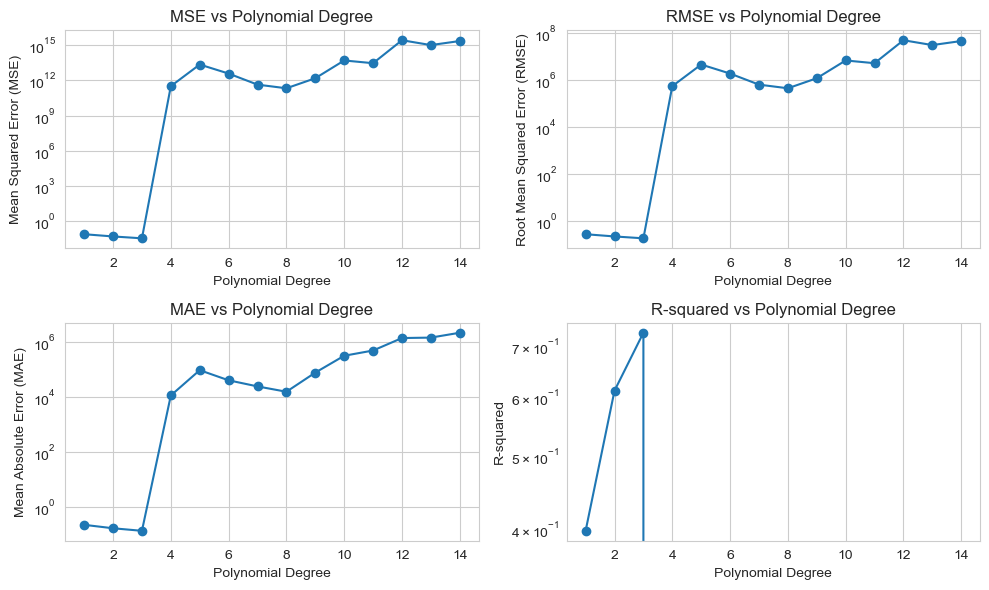

In [6]:
#Polynomial Regression without regularization

#define list for polynomial degrees we shall compare and establish lists for the metrics we employ  
degrees = np.arange(1, 15)
mse_values = []
rmse_values = []
mae_values = []
r2_values = []

#iterate over degrees list to calculate the different metrics for each polynomial degree using a polynomial regression
for degree in degrees:

    #create polynomial features for the training set and validation set
    poly_features = PolynomialFeatures(degree=degree)
    site_1_X_train_poly = poly_features.fit_transform(site_1_X_train)
    site_1_X_val_poly = poly_features.transform(site_1_X_val)

    #create object for linear regression and train the model
    model = LinearRegression()
    model.fit(site_1_X_train_poly, site_1_y_train)

    #use model to predict for the validation data
    y_pred = model.predict(site_1_X_val_poly)

    #calculate performance metrics
    mse = mean_squared_error(site_1_y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(site_1_y_val, y_pred)
    r2 = r2_score(site_1_y_val, y_pred)

    #append calculated values to lists
    mse_values.append(mse)
    rmse_values.append(rmse)
    mae_values.append(mae)
    r2_values.append(r2)

#create plots for each metric
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(degrees, mse_values, marker="o")
plt.yscale("log")
plt.title("MSE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(degrees, rmse_values, marker="o")
plt.yscale("log")
plt.title("RMSE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(degrees, mae_values, marker="o")
plt.yscale("log")
plt.title("MAE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Absolute Error (MAE)")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(degrees, r2_values, marker="o")
plt.yscale("log")
plt.title("R-squared vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("R-squared")
plt.grid(True)

plt.tight_layout()
plt.show()

The metrics are not satisfactory. Especially the the r-squared metric shows that already with degree 5, the model does not represent a good fit to the data whatsoever. Similar results can be seen within the other visualizations. We shall try to utilize regularization to achieve better results


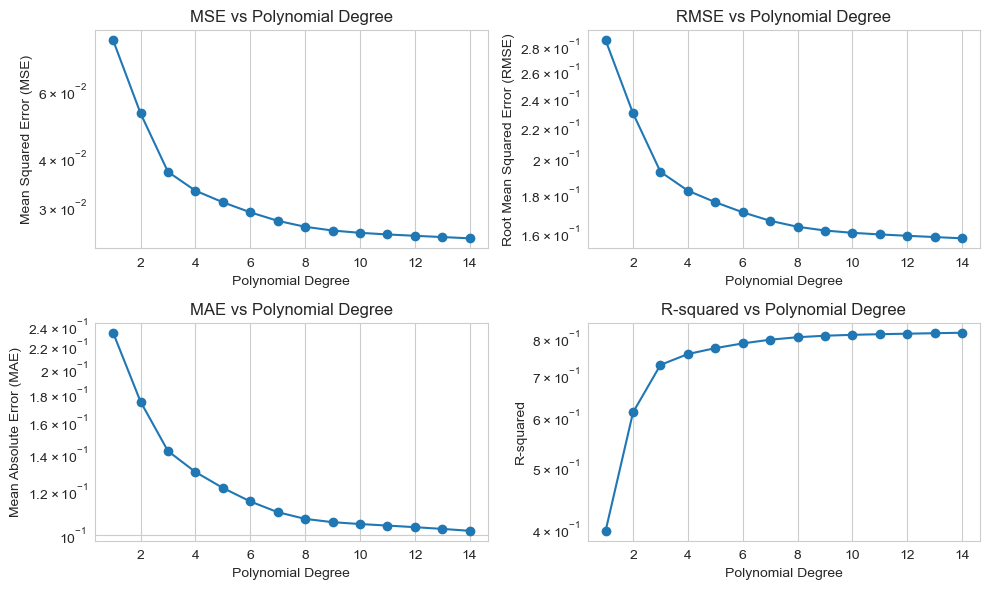

In [7]:
#Polynomial Regression with L2 regularization

#define list for polynomial degrees we shall compare and establish lists for the metrics we employ, as well as the different
#alpha values we test for the regularization
degrees = np.arange(1, 15)
mse_values = []
rmse_values = []
mae_values = []
r2_values = []

#iterate over degrees list to calculate the different metrics for each polynomial degree using a polynomial regression and apply regularization
for degree in degrees:

    #create polynomial features for the training set and validation set
    poly_features = PolynomialFeatures(degree=degree)
    site_1_X_train_poly = poly_features.fit_transform(site_1_X_train)
    site_1_X_val_poly = poly_features.transform(site_1_X_val)

    #create ridge object for the regularized polynomial regression and train the model
    model = Ridge(alpha = 0.25)
    model.fit(site_1_X_train_poly, site_1_y_train)

    #use model to predict for the validation data
    y_pred = model.predict(site_1_X_val_poly)

    #calculate performance metrics
    mse = mean_squared_error(site_1_y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(site_1_y_val, y_pred)
    r2 = r2_score(site_1_y_val, y_pred)
    
    #append calculated values to lists
    mse_values.append(mse)
    rmse_values.append(rmse)
    mae_values.append(mae)
    r2_values.append(r2)

#create plots for each metric
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(degrees, mse_values, marker="o")
plt.yscale("log")
plt.title("MSE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(degrees, rmse_values, marker="o")
plt.yscale("log")
plt.title("RMSE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(degrees, mae_values, marker="o")
plt.yscale("log")
plt.title("MAE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Absolute Error (MAE)")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(degrees, r2_values, marker="o")
plt.yscale("log")
plt.title("R-squared vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("R-squared")
plt.grid(True)

plt.tight_layout()
plt.show()

The results are far better than without any regularization. The graphs show that with increasing polynomial degree the key metrics improve but stagnate at around the 6th degree.

As an additional hyperparameter, let us also consider the amount of regularizaion (alpha) we apply to our model.

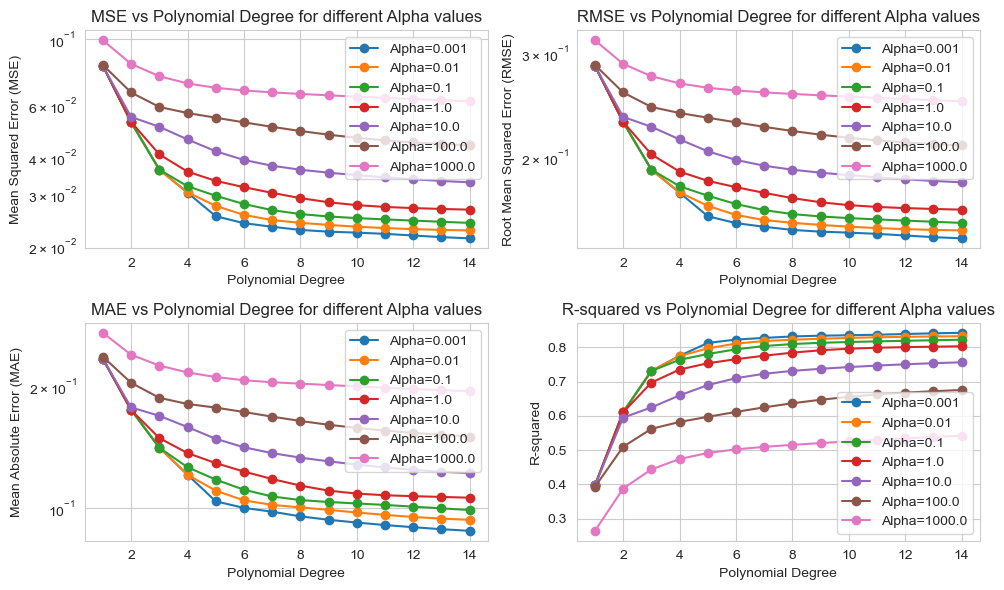

In [8]:
#Polynomial Regression with L2-regularization and different alpha values

#define list for polynomial degrees we shall compare and establish lists for the metrics we employ, as well as the different
#alpha values we test for the regularization
degrees = np.arange(1, 15)
alpha_values = np.logspace(-3, 3, 7)
mse_values = np.zeros((len(alpha_values), len(degrees)))
rmse_values = np.zeros((len(alpha_values), len(degrees)))
mae_values = np.zeros((len(alpha_values), len(degrees)))
r2_values = np.zeros((len(alpha_values), len(degrees)))

#iterate over degrees list and alpha values to calculate the different metrics for each combination of polynomial and
#alpha degree using a polynomial regression and apply regularization
for i, alpha in enumerate(alpha_values):
    for j, degree in enumerate(degrees):

        #create polynomial features for the training set and validation set
        poly_features = PolynomialFeatures(degree=degree)
        site_1_X_train_poly = poly_features.fit_transform(site_1_X_train)
        site_1_X_val_poly = poly_features.transform(site_1_X_val)

        #create ridge object for the regularized polynomial regression and train the model
        model = Ridge(alpha=alpha)
        model.fit(site_1_X_train_poly, site_1_y_train)

        #use model to predict for the validation data
        y_pred = model.predict(site_1_X_val_poly)

        #calculate performance metrics
        mse = mean_squared_error(site_1_y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(site_1_y_val, y_pred)
        r2 = r2_score(site_1_y_val, y_pred)

        #append calculated values to lists
        mse_values[i, j] = mse
        rmse_values[i, j] = rmse
        mae_values[i, j] = mae
        r2_values[i, j] = r2

#create plots for each metric
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, mse_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale("log")
plt.title("MSE vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, rmse_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale("log")
plt.title("RMSE vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, mae_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale("log")
plt.title("MAE vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, r2_values[i], marker='o', label=f"Alpha={alpha}")
plt.title("R-squared vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("R-squared")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

As we can see (at least in the first 14 instances) the benchmarks for the polynomial regression improve with higher polynomial degrees. However, we do not want to risk any overfitting, therefore, we will say that a polynomial degree of 6 is sufficient for our model.

Furthermore, lower alpha values for the ridge regression also improve the outcomes for the benchmarks. Choosing alpha as too low, however, increases the risk of overfitting to the training set and results in worse generalization. Thus, we will choose an alpha of 0.11.

Now, let us also look at the public site and train an analog polnyomial model.

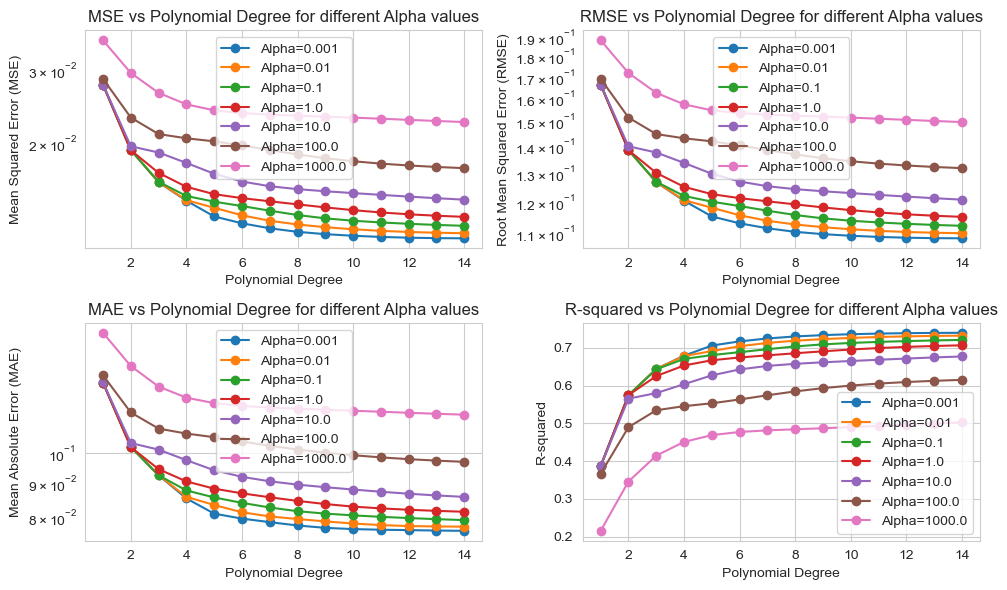

In [9]:
#Polynomial Regression with L2-regularization and different alpha values

#define list for polynomial degrees we shall compare and establish lists for the metrics we employ, as well as the different
#alpha values we test for the regularization
degrees = np.arange(1, 15)
alpha_values = np.logspace(-3, 3, 7)
mse_values = np.zeros((len(alpha_values), len(degrees)))
rmse_values = np.zeros((len(alpha_values), len(degrees)))
mae_values = np.zeros((len(alpha_values), len(degrees)))
r2_values = np.zeros((len(alpha_values), len(degrees)))

#iterate over degrees list and alpha values to calculate the different metrics for each combination of polynomial and
#alpha degree using a polynomial regression and apply regularization
for i, alpha in enumerate(alpha_values):
    for j, degree in enumerate(degrees):

        #create polynomial features for the training set and validation set
        poly_features = PolynomialFeatures(degree=degree)
        site_2_X_train_poly = poly_features.fit_transform(site_2_X_train)
        site_2_X_val_poly = poly_features.transform(site_2_X_val)

        #create ridge object for the regularized polynomial regression and train the model
        model = Ridge(alpha=alpha)
        model.fit(site_2_X_train_poly, site_2_y_train)

        #use model to predict for the validation data
        y_pred = model.predict(site_2_X_val_poly)

        #calculate performance metrics
        mse = mean_squared_error(site_2_y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(site_2_y_val, y_pred)
        r2 = r2_score(site_2_y_val, y_pred)

        #append calculated values to lists
        mse_values[i, j] = mse
        rmse_values[i, j] = rmse
        mae_values[i, j] = mae
        r2_values[i, j] = r2

#create plots for each metric
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, mse_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale("log")
plt.title("MSE vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, rmse_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale("log")
plt.title("RMSE vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, mae_values[i], marker='o', label=f'Alpha={alpha}')
plt.yscale("log")
plt.title("MAE vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
for i, alpha in enumerate(alpha_values):
    plt.plot(degrees, r2_values[i], marker='o', label=f"Alpha={alpha}")
plt.title("R-squared vs Polynomial Degree for different Alpha values")
plt.xlabel("Polynomial Degree")
plt.ylabel("R-squared")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Decision Tree

Our next approach used to create a predictive model, we opted for a decision tree and a corresponding decision tree regression. In addition, GridSearch supports the search and selection of the best possible values for the hyperparameters. We decided to stick to the following choice of hyperparameters to control both the complexity and predictive power of the decision tree:
- "max_depth": Defines maximal allowed depth of the tree.
- "min_samples_split": Defines minimal requirement of samples to split a node. To prevent the Decision to split up too much in smaller subsets due to noise in data.  
- "min_samples_leaf": Defines the minimum number of samples that must be in a leaf node. If any resulting leaf node would have fewer samples than "min_samples_leaf" after a split, the split is not performed and the node becomes a leaf node directly.
- "max_features": Specifies the maximum number of features to consider when searching for the best split at each node. 

Best Hyperparameters: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 25, 'min_samples_split': 75}


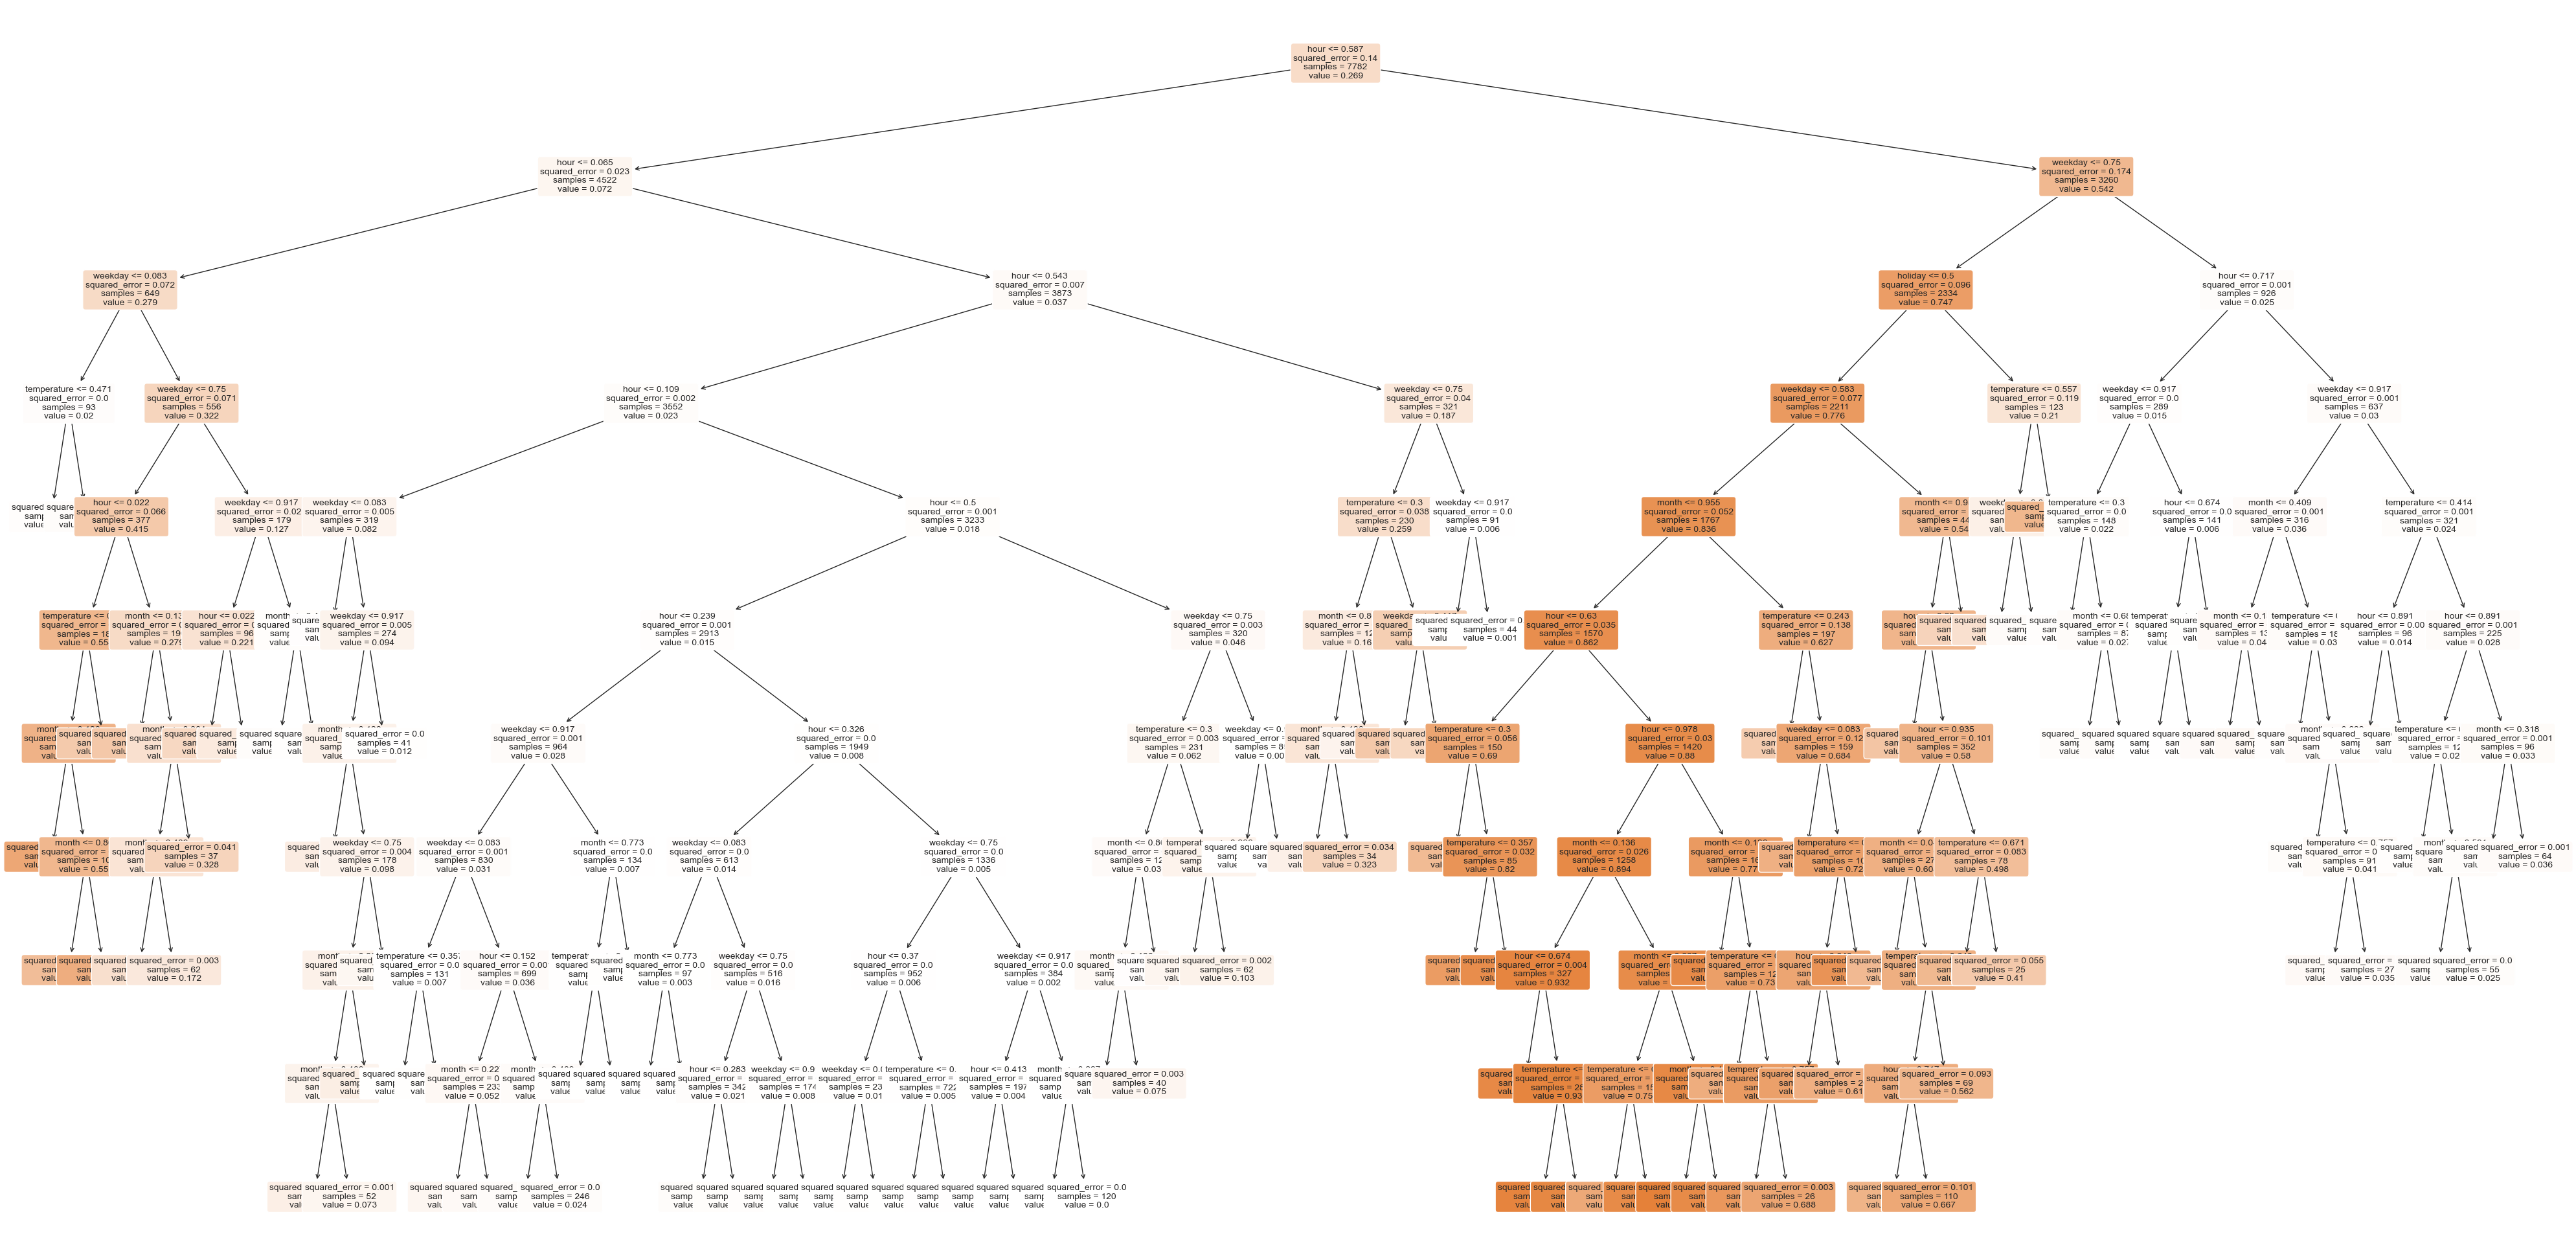

Number of Nodes: 213
Number of Leaves: 107
MSE on Validation Set: 0.017485424309184077
RMSE on Validation Set: 0.13223246314420706
MAE on Validation Set: 0.06498282612922679
R2 on Validation Set: 0.8703605466750933


In [10]:
# Define the Decision Tree Regression model
dtree_model = DecisionTreeRegressor()

# Define the hyperparameter grid for GridSearch to find "best possible" Decision Tree
param_grid = {
    "max_depth": [5, 7, 10],  
    "min_samples_split": [75, 100, 150],  
    "min_samples_leaf": [15, 25, 35],
    "max_features": [0.5, 0.7, 1.0]
}

grid_search = GridSearchCV(dtree_model, param_grid, scoring="neg_mean_squared_error", cv=5)

# Train the model via the use of GridSearch on train data set
grid_search.fit(site_1_X_train, site_1_y_train)

# Save the selection of the best hyperparameters and trained model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Display selection of best hyperparameters
print("Best Hyperparameters:", best_params)

# Plot the best Decision Tree
plt.figure(figsize=(50, 25))
plot_tree(best_model, filled=True, feature_names=site_1_X.columns, rounded=True, fontsize=10)
plt.show()

# Save the number of nodes and leaves of the best Decision Tree
num_nodes = best_model.tree_.node_count
num_leaves = best_model.get_n_leaves()

# Evaluate performance of our model via validation set; could be used for further adjustments of the hyperparameters values or hyperparameter selection itself 
y_pred = best_model.predict(site_1_X_val)
mse = mean_squared_error(site_1_y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(site_1_y_val, y_pred)
r2 = r2_score(site_1_y_val, y_pred)

# Display performance measures
print("Number of Nodes:", num_nodes)
print("Number of Leaves:", num_leaves)
print("MSE on Validation Set:", mse)
print("RMSE on Validation Set:", rmse)
print("MAE on Validation Set:", mae)
print("R2 on Validation Set:", r2)

Best Hyperparameters: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 50, 'min_samples_split': 75}


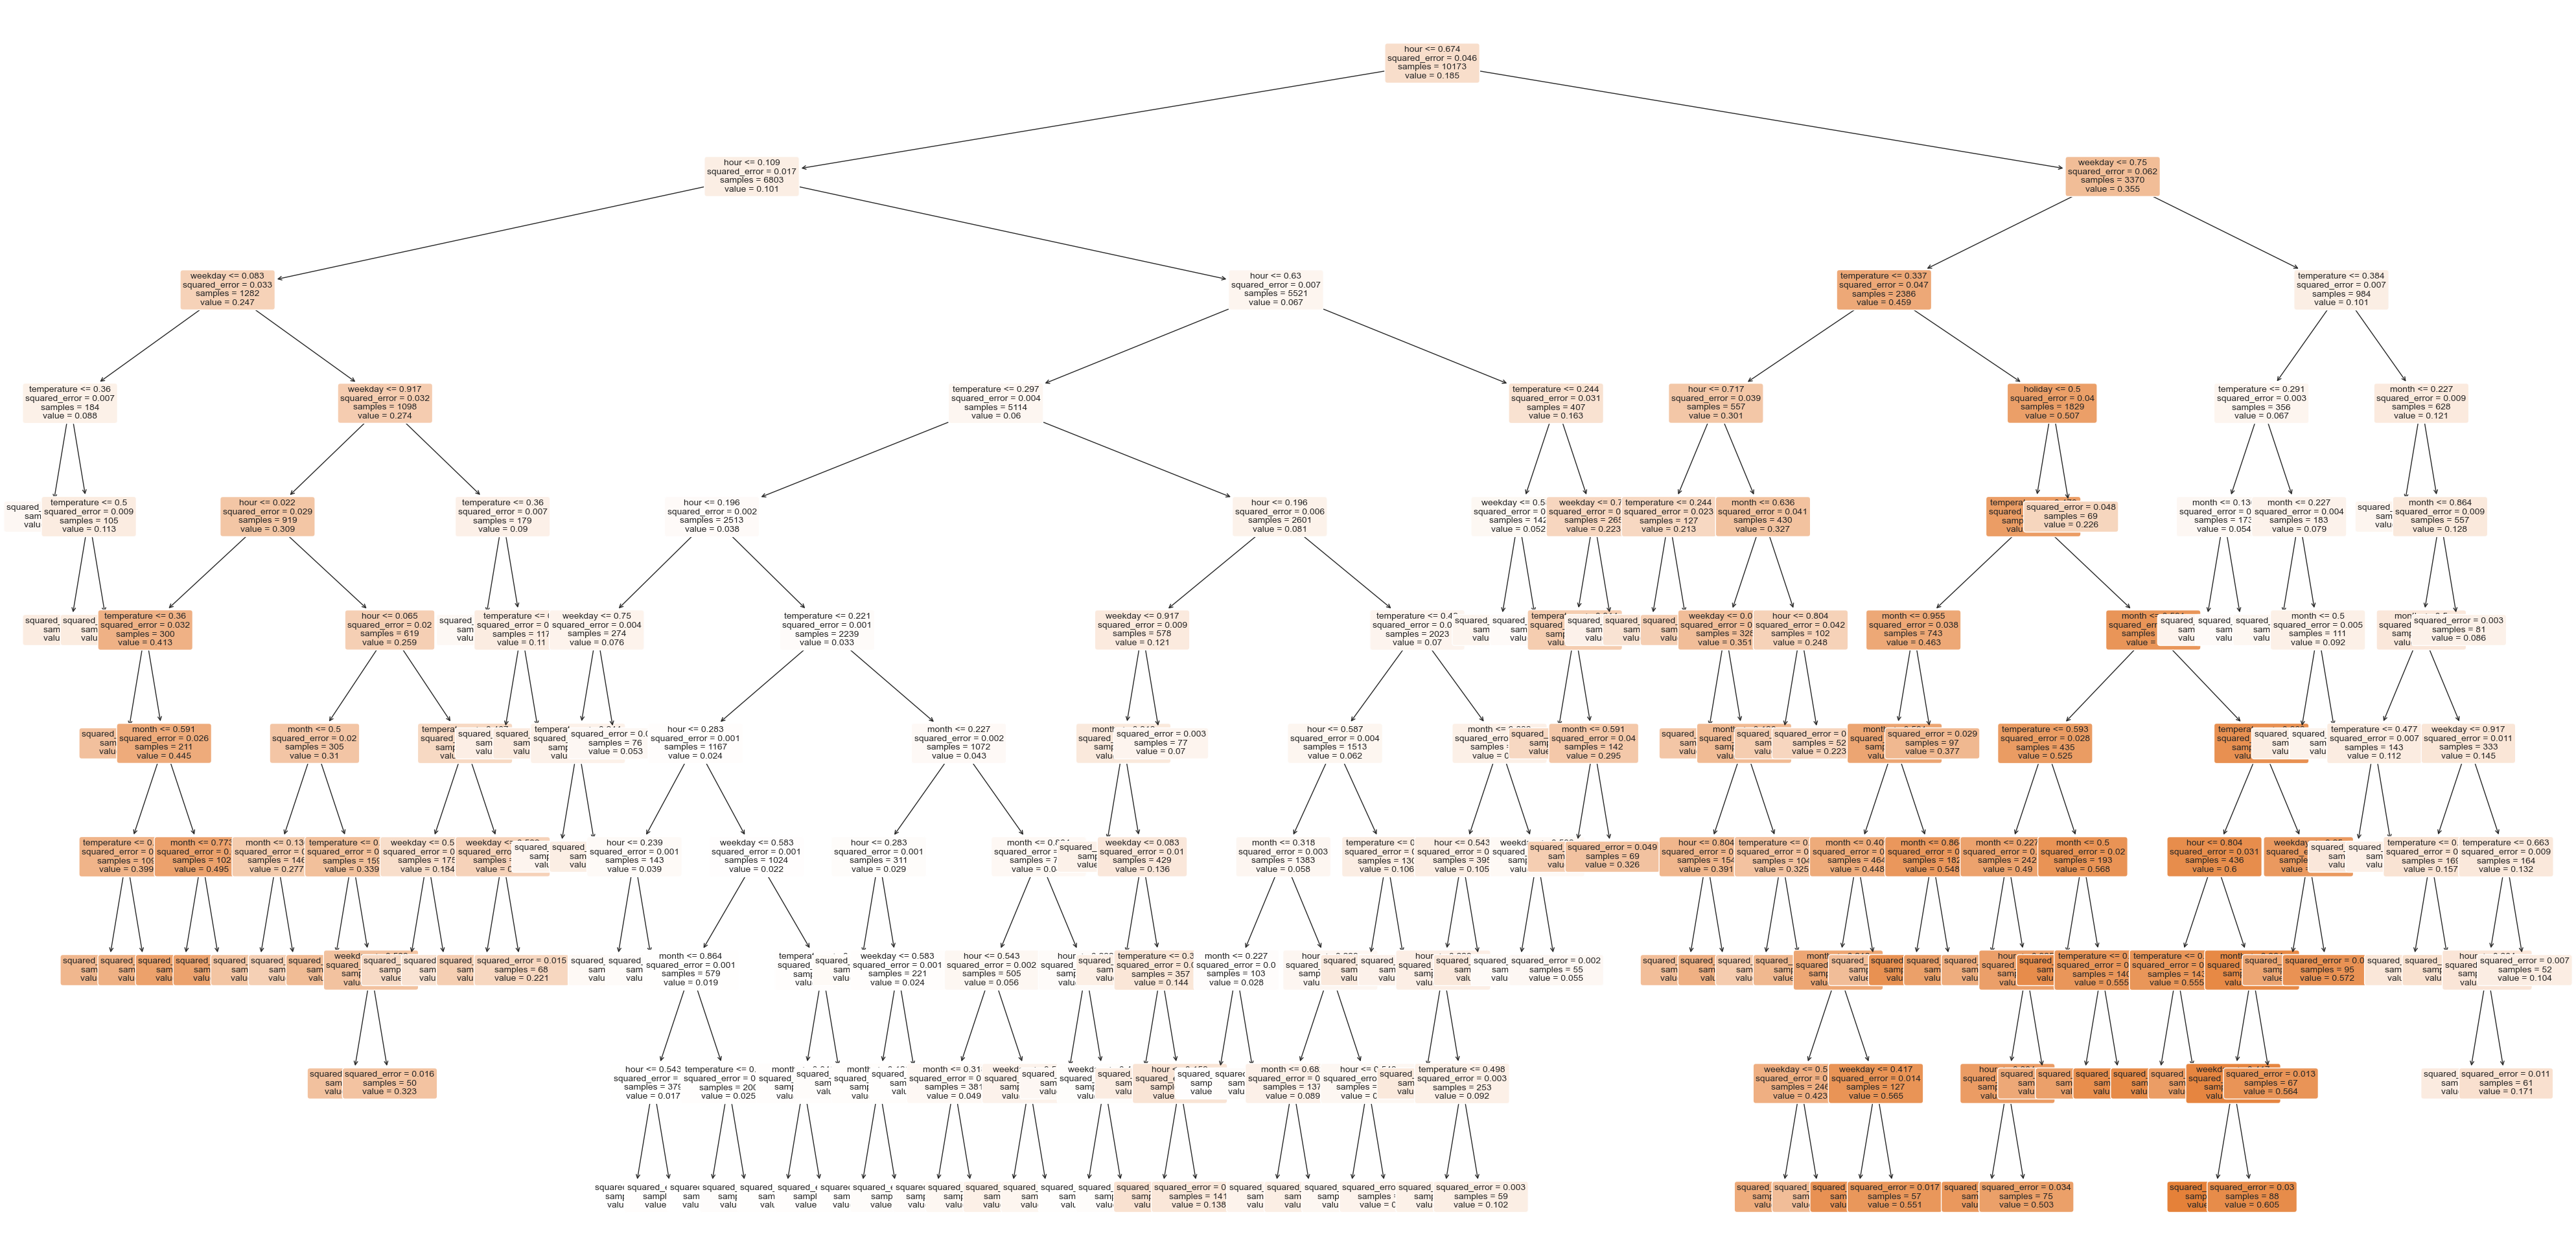

Number of Nodes: 229
Number of Leaves: 115
MSE on Validation Set: 0.012828614307605507
RMSE on Validation Set: 0.11326347296284671
MAE on Validation Set: 0.07992639318355702
R2 on Validation Set: 0.7154593827787341


In [11]:
# Define the Decision Tree Regression model
dtree_model_site_2 = DecisionTreeRegressor()

# Define the hyperparameter grid for GridSearch to find "best possible" Decision Tree
param_grid_site_2 = {
    "max_depth": [5, 7, 10], 
    "min_samples_split": [75, 100, 150, 250, 500], 
    "min_samples_leaf": [50, 100, 150, 250, 500], 
    "max_features": [0.5, 0.7, 1.0]
}

grid_search_site_2 = GridSearchCV(dtree_model_site_2, param_grid_site_2, scoring="neg_mean_squared_error", cv=5)

# Train the model via the use of GridSearch on train data set
grid_search_site_2.fit(site_2_X_train, site_2_y_train)

# Save the selection of the best hyperparameters and trained model
best_params_site_2 = grid_search_site_2.best_params_
best_model_site_2 = grid_search_site_2.best_estimator_

# Display selection of best hyperparameters
print("Best Hyperparameters:", best_params_site_2)

# Plot the best Decision Tree
plt.figure(figsize=(50, 25))
plot_tree(best_model_site_2, filled=True, feature_names=site_2_X.columns, rounded=True, fontsize=10)
plt.show()

# Save the number of nodes and leaves of the best Decision Tree
num_nodes_site_2 = best_model_site_2.tree_.node_count
num_leaves_site_2 = best_model_site_2.get_n_leaves()

# Evaluate performance of our model via validation set; could be used for further adjustments of the hyperparameters values or hyperparameter selection itself 
y_pred = best_model_site_2.predict(site_2_X_val)
mse = mean_squared_error(site_2_y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(site_2_y_val, y_pred)
r2 = r2_score(site_2_y_val, y_pred)

# Display performance measures
print("Number of Nodes:", num_nodes_site_2)
print("Number of Leaves:", num_leaves_site_2)
print("MSE on Validation Set:", mse)
print("RMSE on Validation Set:", rmse)
print("MAE on Validation Set:", mae)
print("R2 on Validation Set:", r2)

In [12]:
# Evaluate the best model on the test set
y_test_pred = best_model.predict(site_1_X_test)

# Calculate performance measures
rmse_test = np.sqrt(mean_squared_error(site_1_y_test, y_test_pred))
mse = mean_squared_error(site_1_y_test, y_test_pred)
mae = mean_absolute_error(site_1_y_test, y_test_pred)
r2 = r2_score(site_1_y_test, y_test_pred)

# Display performance measures on test set
print("RMSE on Test Set:", rmse_test)
print("MSE on Test Set:", mse)
print("MAE:", mae)
print("R2:", r2)

RMSE on Test Set: 0.14071146246287825
MSE on Test Set: 0.019799715668441995
MAE: 0.06847464809046848
R2: 0.8610982210665714


In [13]:
# Evaluate the best model on the test set
y_test_pred = best_model_site_2.predict(site_2_X_test)

# Calculate performance measures
rmse_test = np.sqrt(mean_squared_error(site_2_y_test, y_test_pred))
mse = mean_squared_error(site_2_y_test, y_test_pred)
mae = mean_absolute_error(site_2_y_test, y_test_pred)
r2 = r2_score(site_2_y_test, y_test_pred)

# Display performance measures
print("Root Mean Squared Error on Test Set:", rmse_test)
print("Mean Squared Error on Test Set:", mse)
print("MAE:", mae)
print("R2:", r2)

Root Mean Squared Error on Test Set: 0.11541470163718177
Mean Squared Error on Test Set: 0.013320553353999688
MAE: 0.08102796275836549
R2: 0.7080401788674139


## Neural Network

In [14]:
def getMetrics(model, siteNo):
    if(siteNo==1):
        x_test = site_1_X_test
        y_test = site_1_y_test
    else:
        x_test = site_2_X_test
        y_test = site_2_y_test
    eval = model.evaluate(x_test,y_test)
    print("eval: " + str(eval[1]))
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    print("r2: " + str(r2))

In [15]:
tf.random.set_seed(42)
# Build a relatively simple neural net with a few layers
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_1.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_1 = model_1.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 100)



Epoch 1/100


244/244 [==============================] - 1s 1ms/step - loss: 0.0631 - mae: 0.1757 - val_loss: 0.0487 - val_mae: 0.1504
Epoch 2/100
244/244 [==============================] - 0s 905us/step - loss: 0.0443 - mae: 0.1373 - val_loss: 0.0365 - val_mae: 0.1185
Epoch 3/100
244/244 [==============================] - 0s 908us/step - loss: 0.0319 - mae: 0.1098 - val_loss: 0.0250 - val_mae: 0.0898
Epoch 4/100
244/244 [==============================] - 0s 886us/step - loss: 0.0254 - mae: 0.0944 - val_loss: 0.0225 - val_mae: 0.0812
Epoch 5/100
244/244 [==============================] - 0s 901us/step - loss: 0.0233 - mae: 0.0873 - val_loss: 0.0249 - val_mae: 0.0868
Epoch 6/100
244/244 [==============================] - 0s 890us/step - loss: 0.0235 - mae: 0.0883 - val_loss: 0.0201 - val_mae: 0.0826
Epoch 7/100
244/244 [==============================] - 0s 899us/step - loss: 0.0217 - mae: 0.0825 - val_loss: 0.0219 - val_mae: 0.0887
Epoch 8/100
244/244 [==============================] 

<Axes: >

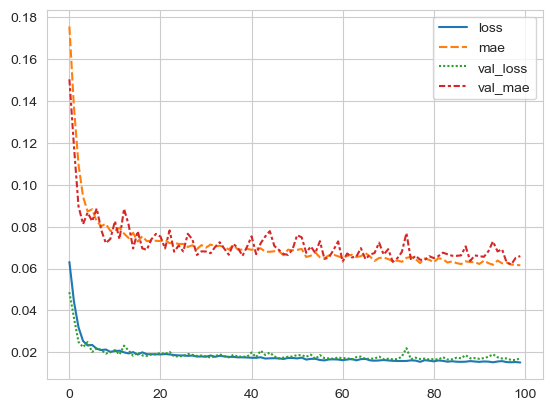

In [16]:
sns.lineplot(history_model_1.history)

While the decrease of loss levels out relatively quick after about 10 epochs, there is still a slight downward trend recognizable. Because the model complexity and the amount of data is rather low, epochs don't take very long to run. We will use an early stopping callback to let the training run for a high amount of epochs, until there is a divergence between training and validation loss, which would indicate overfitting.

In [17]:
# Early stopping callback that monitors validation loss and stops training after it stops decreasing for more than 25 epochs. Restores the model to the best weights it achieved on val loss afterwards.
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 25, restore_best_weights = True)

# Build a relatively simple neural net with a few layers
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_2.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_2 = model_2.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 10000,
                    callbacks = [early_stop])

Epoch 1/10000
244/244 [==============================] - 1s 1ms/step - loss: 0.0647 - mae: 0.1813 - val_loss: 0.0493 - val_mae: 0.1513
Epoch 2/10000
244/244 [==============================] - 0s 887us/step - loss: 0.0451 - mae: 0.1412 - val_loss: 0.0367 - val_mae: 0.1236
Epoch 3/10000
244/244 [==============================] - 0s 871us/step - loss: 0.0355 - mae: 0.1201 - val_loss: 0.0295 - val_mae: 0.1092
Epoch 4/10000
244/244 [==============================] - 0s 864us/step - loss: 0.0295 - mae: 0.1074 - val_loss: 0.0254 - val_mae: 0.0940
Epoch 5/10000
244/244 [==============================] - 0s 868us/step - loss: 0.0261 - mae: 0.0992 - val_loss: 0.0274 - val_mae: 0.1036
Epoch 6/10000
244/244 [==============================] - 0s 893us/step - loss: 0.0248 - mae: 0.0962 - val_loss: 0.0277 - val_mae: 0.1233
Epoch 7/10000
244/244 [==============================] - 0s 874us/step - loss: 0.0224 - mae: 0.0886 - val_loss: 0.0226 - val_mae: 0.0906
Epoch 8/10000
244/244 [====================

<Axes: >

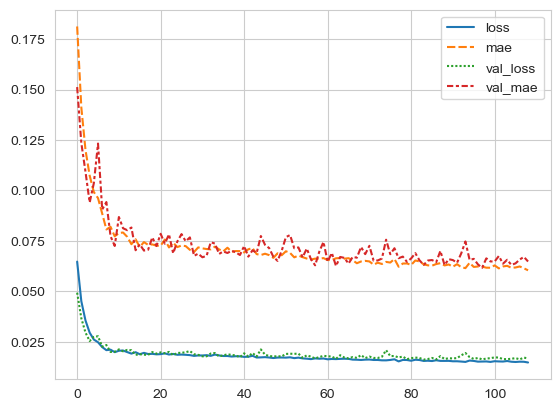

In [18]:
sns.lineplot(history_model_2.history)

Training stops after 130 epochs. With the early stopping, this means that validation loss stops decreasing after around 100 epochs. With there still being a downward trend in the training loss discernible at the end, this indicates that the model starts over-fitting to the training data at the end. One way to counter this in the model architecture is by using dropout layers in the first few layers. We'll add two drop-out layers in the beginning, with a drop-out ratio of 10% and increase the number epochs to 300.

In [19]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_3.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_3 = model_3.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 300,
                    callbacks = [early_stop])

Epoch 1/300
244/244 [==============================] - 1s 1ms/step - loss: 0.0735 - mae: 0.1950 - val_loss: 0.0525 - val_mae: 0.1574
Epoch 2/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0509 - mae: 0.1516 - val_loss: 0.0400 - val_mae: 0.1284
Epoch 3/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0422 - mae: 0.1327 - val_loss: 0.0341 - val_mae: 0.1173
Epoch 4/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0356 - mae: 0.1189 - val_loss: 0.0285 - val_mae: 0.0974
Epoch 5/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0294 - mae: 0.1045 - val_loss: 0.0248 - val_mae: 0.0910
Epoch 6/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0277 - mae: 0.0989 - val_loss: 0.0238 - val_mae: 0.0835
Epoch 7/300
244/244 [==============================] - 0s 1ms/step - loss: 0.0254 - mae: 0.0929 - val_loss: 0.0217 - val_mae: 0.0790
Epoch 8/300
244/244 [==============================] - 0s 1ms/step - 

<Axes: >

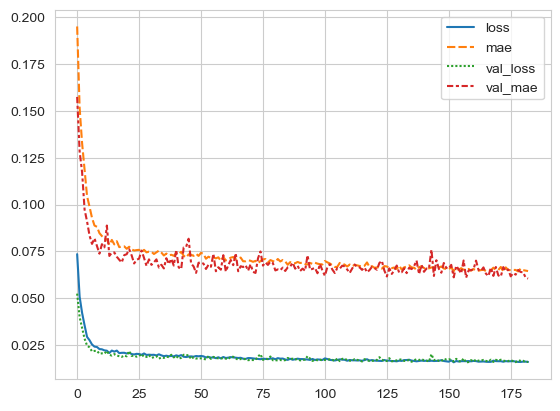

In [20]:
sns.lineplot(history_model_3.history)

In [21]:
model_3_site_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(20, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_3_site_2.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_3_site_2 = model_3_site_2.fit(site_2_X_train,
                    site_2_y_train,
                    validation_data = (site_2_X_val,site_2_y_val),
                    epochs = 150)

Epoch 1/150
318/318 [==============================] - 1s 1ms/step - loss: 0.0264 - mae: 0.1188 - val_loss: 0.0189 - val_mae: 0.1011
Epoch 2/150
318/318 [==============================] - 0s 1ms/step - loss: 0.0197 - mae: 0.0986 - val_loss: 0.0179 - val_mae: 0.0944
Epoch 3/150
318/318 [==============================] - 0s 1ms/step - loss: 0.0183 - mae: 0.0935 - val_loss: 0.0159 - val_mae: 0.0865
Epoch 4/150
318/318 [==============================] - 0s 1ms/step - loss: 0.0171 - mae: 0.0906 - val_loss: 0.0152 - val_mae: 0.0856
Epoch 5/150
318/318 [==============================] - 0s 1ms/step - loss: 0.0159 - mae: 0.0873 - val_loss: 0.0142 - val_mae: 0.0828
Epoch 6/150
318/318 [==============================] - 0s 1ms/step - loss: 0.0156 - mae: 0.0864 - val_loss: 0.0140 - val_mae: 0.0843
Epoch 7/150
318/318 [==============================] - 0s 1ms/step - loss: 0.0150 - mae: 0.0851 - val_loss: 0.0154 - val_mae: 0.0879
Epoch 8/150
318/318 [==============================] - 0s 1ms/step - 

<Axes: >

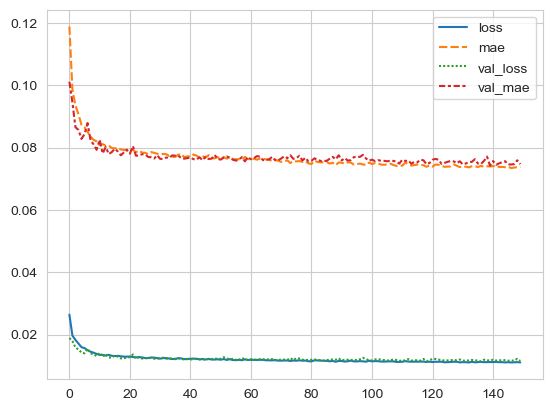

In [22]:
sns.lineplot(history_model_3_site_2.history)

While not big, training a model of the same architecture on site 2 training data, yields a small difference in final MAE. A possible for this explanation could be the difference between the two sites. Site 1, being the private charging site at a company, will probably have charging events that look more alike than site 2, the public charging site. As a final step, let's try scaling up the model architecture, using more layers with a higher amount of neurons per layer.

In [23]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(1000, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(500, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(500, activation = "relu"),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_4.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_4 = model_4.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 300,
                    callbacks = [early_stop])

Epoch 1/300
244/244 [==============================] - 1s 4ms/step - loss: 0.0559 - mae: 0.1538 - val_loss: 0.0380 - val_mae: 0.1240
Epoch 2/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0357 - mae: 0.1116 - val_loss: 0.0241 - val_mae: 0.0897
Epoch 3/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0276 - mae: 0.0943 - val_loss: 0.0259 - val_mae: 0.0843
Epoch 4/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0254 - mae: 0.0873 - val_loss: 0.0209 - val_mae: 0.0758
Epoch 5/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0235 - mae: 0.0836 - val_loss: 0.0238 - val_mae: 0.0830
Epoch 6/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0244 - mae: 0.0857 - val_loss: 0.0247 - val_mae: 0.0888
Epoch 7/300
244/244 [==============================] - 1s 3ms/step - loss: 0.0234 - mae: 0.0834 - val_loss: 0.0228 - val_mae: 0.0837
Epoch 8/300
244/244 [==============================] - 1s 3ms/step - 

<Axes: >

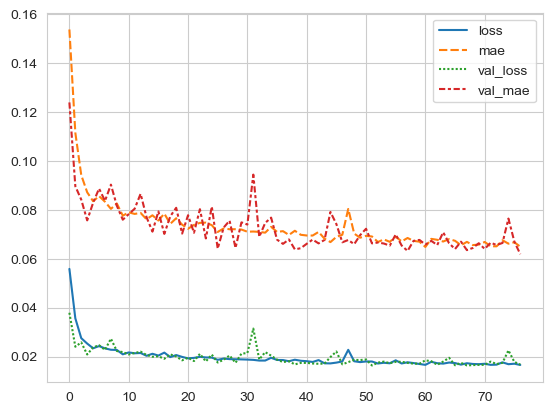

In [24]:
sns.lineplot(history_model_4.history)

The results of this are similar to the simpler architecture of model 3, with a higher complexity, resulting in longer training and inferencing times. While this is not really relevant to our current situation, this could lead to problems when trying to scale the system up. Let's try the opposite, and use an even simpler model.

In [25]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(5, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model_5.compile(loss = tf.keras.losses.mse,
              optimizer = "adam",
              metrics = ["mae"])
history_model_5 = model_5.fit(site_1_X_train,
                    site_1_y_train,
                    validation_data = (site_1_X_val,site_1_y_val),
                    epochs = 300,
                    callbacks = [early_stop])

Epoch 1/300
244/244 [==============================] - 1s 1ms/step - loss: 0.1017 - mae: 0.2512 - val_loss: 0.0726 - val_mae: 0.2140
Epoch 2/300
244/244 [==============================] - 0s 835us/step - loss: 0.0736 - mae: 0.2037 - val_loss: 0.0654 - val_mae: 0.1917
Epoch 3/300
244/244 [==============================] - 0s 861us/step - loss: 0.0683 - mae: 0.1888 - val_loss: 0.0619 - val_mae: 0.1829
Epoch 4/300
244/244 [==============================] - 0s 848us/step - loss: 0.0662 - mae: 0.1842 - val_loss: 0.0605 - val_mae: 0.1726
Epoch 5/300
244/244 [==============================] - 0s 818us/step - loss: 0.0635 - mae: 0.1781 - val_loss: 0.0584 - val_mae: 0.1731
Epoch 6/300
244/244 [==============================] - 0s 821us/step - loss: 0.0631 - mae: 0.1771 - val_loss: 0.0565 - val_mae: 0.1693
Epoch 7/300
244/244 [==============================] - 0s 829us/step - loss: 0.0604 - mae: 0.1719 - val_loss: 0.0550 - val_mae: 0.1663
Epoch 8/300
244/244 [==============================] - 0s

<Axes: >

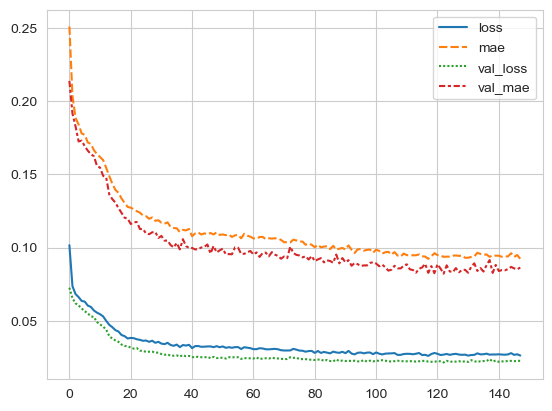

In [26]:
sns.lineplot(history_model_5.history)

The results of this are slightly worse than model 3, with over-fitting creeping in around epoch 90. While further experimentation might yield slightly better results, they are not guaranteed. We will stop here and test the models, both site 1 and site 2, on the testing data to get our final result.

In [27]:
getMetrics(model_3, 1)

82/82 [==============================] - 0s 565us/step - loss: 0.0169 - mae: 0.0633
eval: 0.06326651573181152
82/82 [==============================] - 0s 543us/step
r2: 0.8815709114860832


In [28]:
getMetrics(model_3_site_2, 2)

106/106 [==============================] - 0s 567us/step - loss: 0.0113 - mae: 0.0744
eval: 0.07444365322589874
106/106 [==============================] - 0s 526us/step
r2: 0.7514062034902844
